In [1319]:
import json
from collections import Counter, defaultdict
from itertools import repeat
from typing import Optional, Union

import numpy as np
from tqdm.notebook import tqdm as TQDM

from examples.hierarchical.base.gbif import TAXONOMY_KEYS, resolve_id

with open("hierarchical/restructured/flat_result.json", "r") as f:
    flat_data = json.load(f)

with open("hierarchical/restructured/hierarchical_result.json", "r") as f:
    hierarchical_data = json.load(f)

# with open("hierarchical/restructured/hierarchical_class_index.json.json", "r") as f:
#     di = json.load(f)

def rank_error(
        predictions : Union[list[Union[str, int]], list[tuple[Union[str, int], ...]]], 
        labels : list[Union[int, str]],
        confs : Optional[Union[list[list[float]], list[float]]]=None,
        threshold : float=0.5,
        max_rank : int=3,
        progress : bool=False
    ):
    ranks = []
    correct, incorrect = defaultdict(lambda : 0), defaultdict(lambda : 0)
    if confs is None:
        confs = repeat(None)
    elements = zip(predictions, labels, confs)
    if progress:
        elements = TQDM(elements, total=len(labels))
    for ps, ls, cfs in elements:
        if not isinstance(ps, (list, tuple, dict)):
            ps = [p[0] for p in list(resolve_id(ps).values())]
        ls = [l[0] for l in resolve_id(ls).values()]
        if max_rank is not None:
            ls = ls[:max_rank]
        if cfs is None:
            cfs = repeat(1)
        elif not isinstance(cfs, (list, tuple)):
            cfs = repeat(cfs)
        for lvl, (p, l, c) in enumerate(zip(ps, ls, cfs)):
            if p != l and c >= threshold:
                incorrect[lvl] += 1
            if p == l and c >= threshold:
                correct[lvl] += 1
            if c >= threshold:
                break
        else:
            lvl = lvl + 1
        ranks.append(lvl)
    correct, incorrect = dict(correct), dict(incorrect)
    max_rank = max(max(correct, default=0), max(incorrect, default=0))
    correct = {rank : correct.get(rank, 0) for rank in range(max_rank + 1)}
    incorrect = {rank : incorrect.get(rank, 0) for rank in range(max_rank + 1)}
    prop = {rank : incorrect.get(rank, 0) / max(1, correct.get(rank, 0) + incorrect.get(rank, 0)) for rank in range(max_rank + 1)}
    # return sum(ranks) / len(ranks)
    return correct, incorrect, prop

h_preds = list(zip(*[hierarchical_data[str(lvl)]["preds"] for lvl in range(3)]))
h_confs = list(zip(*[hierarchical_data[str(lvl)]["confs"] for lvl in range(3)]))
print("Hierarchical:", rank_error(h_preds, hierarchical_data["0"]["labels"], h_confs))
print("Flat:", rank_error(flat_data["preds"], flat_data["labels"], flat_data["confs"]))
print("Hierarchical:", rank_error(h_preds, hierarchical_data["0"]["labels"]))
print("Flat:", rank_error(flat_data["preds"], flat_data["labels"]))

Hierarchical: ({0: 4009, 1: 26, 2: 120}, {0: 67, 1: 1, 2: 10}, {0: 0.016437684003925417, 1: 0.037037037037037035, 2: 0.07692307692307693})
Flat: ({0: 3968}, {0: 57}, {0: 0.014161490683229814})
Hierarchical: ({0: 4115}, {0: 185}, {0: 0.04302325581395349})
Flat: ({0: 4102}, {0: 198}, {0: 0.046046511627906975})


In [701]:
a, b = np.quantile(np.linspace(-10., 10., 100), [0, 0.05]).tolist()
a, b

(-10.0, -9.0)

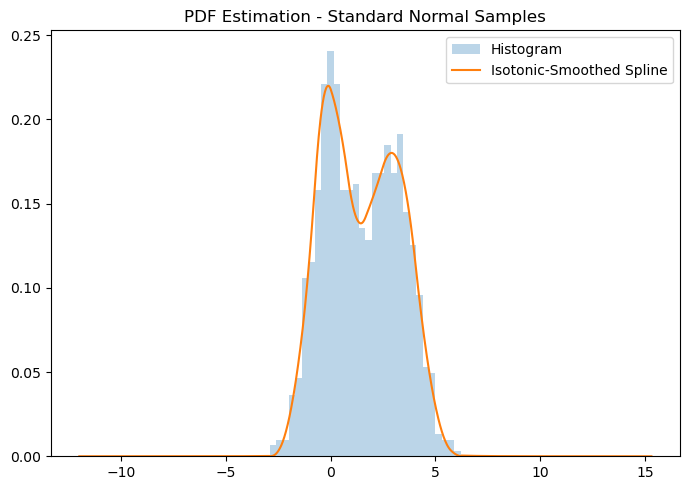

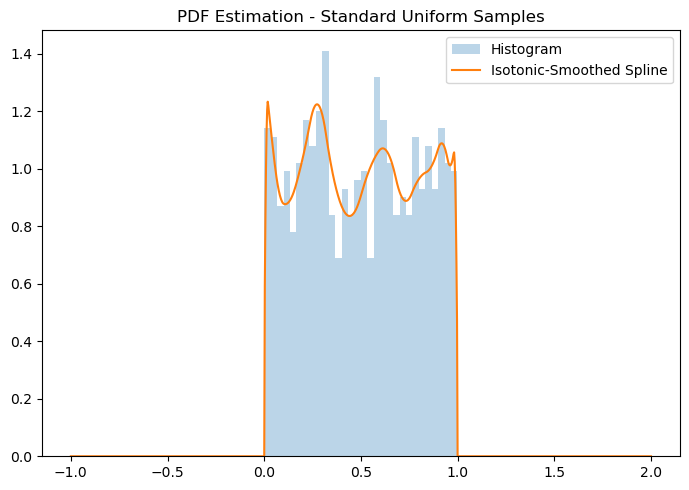

In [1312]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
import cvxpy as cp
from scipy.optimize import root_scalar

def exp_fit(A, B):
    x0, y0 = A
    x1, y1 = B
    if y0 == y1:
        return lambda _ : y0
    if x0 == x1:
        return lambda _ : (y0 + y1)/2
    # print(f'{x0=} {y0=} {x1=} {y1=}')
    return lambda x : y0 * np.exp(np.clip((np.log(y1/y0)/(x1-x0))*(x-x0), a_min=None, a_max=max(np.log(y1/y0), np.log(y0/y1))))

def estimate_pdf(data: np.ndarray, bounds=None, degree=3, num_internal_knots=None,
                 lam=1, boundary_pad=5):
    """
    Estimate PDF with exponential tails for unbounded distributions.
    
    Parameters:
    - data: Input data array
    - bounds: Optional (min, max) tuple for explicit bounds
    - degree: Spline degree (default=3)
    - num_internal_knots: Number of internal knots
    - lam: Regularization strength
    - boundary_pad: Padding fraction for automatic tail extension
    
    Returns:
    - Function that evaluates the PDF at given points
    """
    data = np.asarray(data)
    if num_internal_knots is None:
        num_internal_knots = max(2, int(len(data) ** (1/2)) // 2)
    data_sorted = np.sort(data)
    n = len(data_sorted)
    min_data, max_data = data_sorted[0], data_sorted[-1]
    data_range = max_data - min_data
    
    # Calculate bounds with padding
    if bounds is None:
        xmin = min_data - boundary_pad * data_range
        xmax = max_data + boundary_pad * data_range
        # xmin, xmax = np.finfo(data.dtype).min, np.finfo(data.dtype).max
    else:
        xmin, xmax = bounds
    
    # Adjusted eCDF with tail probabilities
    y = (np.arange(n) + 2)/(n + 3)

    # Chebyshev-spaced internal knots to reduce boundary sensitivity
    cheb_internal = np.polynomial.chebyshev.chebpts1(num_internal_knots + 2)
    cheb_internal = min_data + (cheb_internal - (-1)) / 2 * (max_data - min_data)
    knots = np.concatenate([
        [xmin] + [min_data] * (degree),
        cheb_internal[1:-1],
        [max_data] * (degree) + [xmax]
    ])
    
    B = BSpline.design_matrix(data_sorted, knots, degree)
    num_coeff = B.shape[1]
    
    # Regularization matrix (third differences for smooth derivatives)
    num_coeff = len(knots) - degree - 1
    D = np.zeros((num_coeff-2, num_coeff))
    for i in range(num_coeff-2):
        D[i, i:i+3] = [1, -2, 1]
    
    # Solve constrained optimization
    c = cp.Variable(num_coeff)
    constraints = [
        c[0] >= 0,
        c[-1] <= 1,
        c[1:] >= c[:-1] + 1e-11  # Strict monotonicity
    ]

    # Add slope constraints to limit boundary PDF
    constraints += [
        c[1] - c[0] <= 0.1 * (c[2] - c[1]),
        c[-1] - c[-2] <= 0.1 * (c[-2] - c[-3])
    ]
    
    objective = cp.Minimize(
        cp.sum_squares(B @ c - y) + 
        lam * cp.sum_squares(D @ c)
    )
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS, abstol=1e-8)
    
    if c.value is None:
        raise RuntimeError("Optimization failed")

    # Create central spline
    cdf_spline = BSpline(knots, c.value, degree, extrapolate=False)
    pdf_spline = cdf_spline.derivative()

    # Left tail
    left_tail = (xmin, min_data)
    left_tail = exp_fit((xmin, 1e-20), (min_data, np.quantile(pdf_spline(np.linspace(*np.quantile(data, [0., 0.1]), 100)), 0.05))) if xmin < min_data else lambda x : pdf_spline(min_data)
    # left_tail = exp_fit((xmin, 1e-20), (min_data, pdf_spline(min_data)))

    # Right tail 
    right_tail = (max_data, xmax)
    right_tail = exp_fit((max_data, np.quantile(pdf_spline(np.linspace(*np.quantile(data, [0.9, 1.]), 100)), 0.05)), (xmax, 1e-20)) if xmax > max_data else lambda x : pdf_spline(max_data)
    # right_tail = exp_fit((max_data, pdf_spline(max_data)), (xmax, 1e-20))

    def pdf(x):
        x = np.asarray(x)
        # return np.clip(pdf_spline(x), 0, None)
        pdf_vals = np.zeros_like(x, dtype=float)

        # Left tail
        mask = x < min_data
        pdf_vals[mask] = left_tail(x[mask])

        # Right tail
        mask = x > max_data
        pdf_vals[mask] = right_tail(x[mask])

        # # Central core
        mask = (min_data <= x) & (x <= max_data)
        pdf_vals[mask] = pdf_spline(x[mask])

        return np.clip(pdf_vals, 0, None)
    
    return pdf

def plot_smoothed_pdf_estimators(samples, bounds=None, title=None):
    if bounds is None:
        xmin, xmax = min(samples), max(samples)
    else:
        xmin, xmax = bounds
    ran = xmax - xmin
    xs = np.linspace(xmin-ran, xmax+ran, 1000)
    pdf_iso_smooth = estimate_pdf(samples, bounds)

    plt.figure(figsize=(7, 5))
    plt.hist(samples, bins=30, density=True, alpha=0.3, label='Histogram')
    plt.plot(xs, pdf_iso_smooth(xs), label='Isotonic-Smoothed Spline')
    plt.title(title)
    plt.legend()
    plt.tight_layout()

# Sample sets
# np.random.seed(0)
samples_norm = np.random.normal(np.random.choice(2, 1000, True)*3, 1, size=1000) # / np.random.normal(0, 1, size=100)
samples_unif = np.random.uniform(0, 1, size=1000)

plot_smoothed_pdf_estimators(samples_norm, title="PDF Estimation - Standard Normal Samples")
plot_smoothed_pdf_estimators(samples_unif, [0, 1], title="PDF Estimation - Standard Uniform Samples")
plt.show()


In [1326]:
# from scipy.stats import gaussian_kde

# def estimate_pdf(x, *args):
#     return gaussian_kde(x)

def cross_entropy_ecdf(p_samples, q_samples, bounds=None):
    """
    Approximate H(P, Q) = -E_p[log q(x)] using the empirical PDF.
    """
    q_pdf = estimate_pdf(q_samples, bounds)
    return float(-np.mean(np.log(q_pdf(p_samples))))


def kl_divergence_ecdf(p_samples, q_samples, bounds=None):
    """
    Approximate D_KL(P||Q) = E_p[log(p(x)/q(x))] using the empirical PDF.
    """
    p_pdf = estimate_pdf(p_samples, bounds)
    q_pdf = estimate_pdf(q_samples, bounds)
    return float(np.mean(np.log(p_pdf(p_samples) / q_pdf(p_samples))))

# Example usage
def _example():
    L, U = 0.0, 1.0
    # Example 1: Clipped normals (expectation unknown)
    # p = np.clip(np.random.normal(0.5, 0.1, 1000), 0, 1)
    # q = np.clip(np.random.normal(0.5, 0.1, 1000), 0, 1)
    # Example 2: Unbounded normals with different locations (expectation 2)
    # p = np.random.normal(0, 1, 1000)
    # q = np.random.normal(4, 1, 1000)
    # Example 3: Identical [0,1] uniforms (expectation 0)
    p = np.random.sample(100)
    q = np.random.sample(100)
    # Example 4: Identical standard normals (expectation 0)
    # p = np.random.standard_normal(100)
    # q = np.random.standard_normal(100)

    ce = cross_entropy_ecdf(p, q)
    kl = kl_divergence_ecdf(p, q)
    
    return kl, ce
    # return None, None


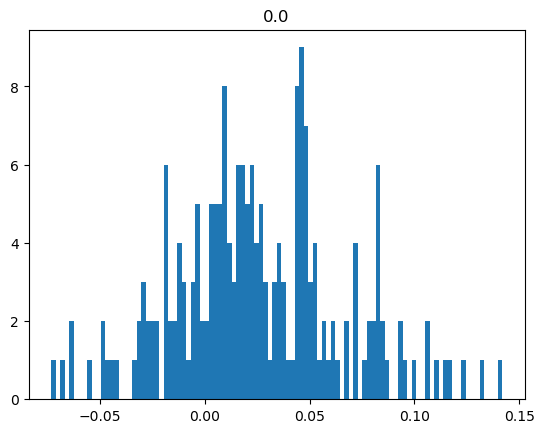

In [1327]:
kls = [_example()[0] for _ in range(200)]
plt.hist(kls, 100)
plt.title(f'{np.mean(kls):.1f}')
plt.show()

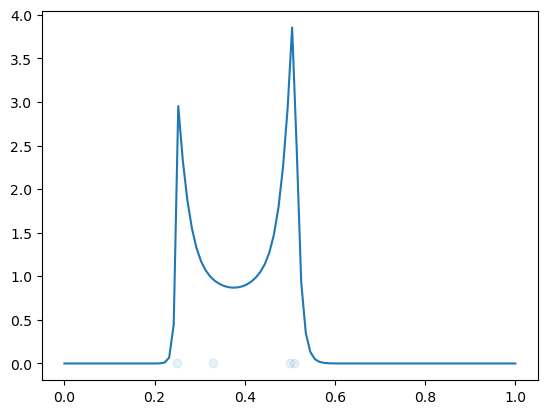

In [1161]:
# s = np.random.standard_normal(1000)
s = [0.25, 0.33, 0.5, 0.51]
# s = np.random.sample(100)

x = np.linspace(0, 1, 100, True)
y = estimate_pdf(s, [0, 1], 5)(x)
plt.plot(x, y)
plt.scatter(s, np.zeros_like(s), alpha=0.1)
plt.show()

In [1320]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

import numpy as np

from scipy.spatial import cKDTree
from scipy.special import digamma

def kl_divergence_knn(P_samples, Q_samples, k=5):
    """
    Estimate the KL divergence D(P || Q) using k-NN method.

    Parameters:
    - P_samples: numpy array of shape (n_samples,) from distribution P
    - Q_samples: numpy array of shape (m_samples,) from distribution Q
    - k: number of nearest neighbors

    Returns:
    - Estimated KL divergence
    """
    P_samples = P_samples.reshape(-1, 1)
    Q_samples = Q_samples.reshape(-1, 1)

    n = P_samples.shape[0]
    m = Q_samples.shape[0]

    # Build k-d trees for efficient neighbor search
    tree_P = cKDTree(P_samples)
    tree_Q = cKDTree(Q_samples)

    # Query k+1 because the point itself is included in its neighbors in P
    r = tree_P.query(P_samples, k=k+1, p=2)[0][:, -1]  # Distance to k-th neighbor in P
    s = tree_Q.query(P_samples, k=k, p=2)[0][:, -1]    # Distance to k-th neighbor in Q

    # Avoid division by zero or log of zero
    eps = 1e-10
    ratio = (s + eps) / (r + eps)

    # Compute the KL divergence estimate
    kl_estimate = (1 / n) * np.sum(np.log(ratio)) + np.log(m / (n - 1))

    return kl_estimate

def cross_entropy_knn(p_samples, q_samples, k=1):
    """
    Estimate the cross-entropy H(P, Q) between two 1D continuous distributions
    using k-nearest neighbor distances.

    Parameters:
    - p_samples: array-like, samples from distribution P
    - q_samples: array-like, samples from distribution Q
    - k: int, number of nearest neighbors

    Returns:
    - Estimated cross-entropy H(P, Q)
    """
    p_samples = np.asarray(p_samples).reshape(-1, 1)
    q_samples = np.asarray(q_samples).reshape(-1, 1)
    n = len(p_samples)
    m = len(q_samples)

    # Build k-d tree for Q samples
    tree_q = cKDTree(q_samples)

    # Query k-th nearest neighbor distances from P to Q
    distances, _ = tree_q.query(p_samples, k=k, p=2)
    if k == 1:
        epsilons = distances
    else:
        epsilons = distances[:, -1]

    # Avoid log(0) by adding a small constant
    epsilons = np.maximum(epsilons, 1e-10)

    # Compute the cross-entropy estimate
    d = 1  # dimensionality
    volume_unit_ball = 2  # Volume of unit ball in 1D
    log_volume = np.log(volume_unit_ball)
    ce_estimate = -digamma(k) + digamma(m) + d * np.mean(np.log(epsilons)) + log_volume

    return ce_estimate

def plot_conf_hist(preds : list[int], labels : list[int], confs : list[float], ax : Axes | None=None, **kwargs):
    correct = np.array([p == l for p, l in zip(preds, labels)])
    confs = np.array(confs)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    
    n, b, _ = ax.hist(confs[correct] , np.linspace(0, 1, int(min(100, sum( correct) / 3)), True), label="Correct"  , density=True, alpha=0.5, color="blue", **kwargs)
    c = (b[:-1] + b[1:])/2
    wm = np.argmax(n)
    cwm = c[wm]
    cm = n[wm]
    ax.vlines(cwm, 0, max(n), colors="blue")

    n, b, _ = ax.hist(confs[~correct], np.linspace(0, 1, int(min(100, sum(~correct) / 3)), True), label="Incorrect", density=True, alpha=0.5, color="orange", **kwargs)
    c = (b[:-1] + b[1:])/2
    wm = np.argmax(n)
    iwm = c[wm]
    im = n[wm]
    ax.vlines(iwm, 0, max(n), colors="orange")

    ym = ax.get_ylim()[1]

    ax.text(cwm, cm + ym/30, s=f'{cwm:.1%}', ha='center', va='top')
    ax.text(iwm, im + ym/30, s=f'{iwm:.1%}', ha='center', va='top')

    ax.legend()

    # Calculate distributional difference
    # kl = kl_divergence_ecdf(confs[correct], confs[~correct], [0, 1])
    # ce = cross_entropy_ecdf(confs[correct], confs[~correct], [0, 1])
    kl = kl_divergence_ecdf(confs[correct], confs[~correct])
    ce = cross_entropy_ecdf(confs[correct], confs[~correct])


    dist_lab = f'KL: {kl:.1f} | Cross-Entropy: {ce:.1f}'
    ax.text((cwm + iwm)/2, (cm + im)/2, dist_lab, ha='center', va='top')

    return ax

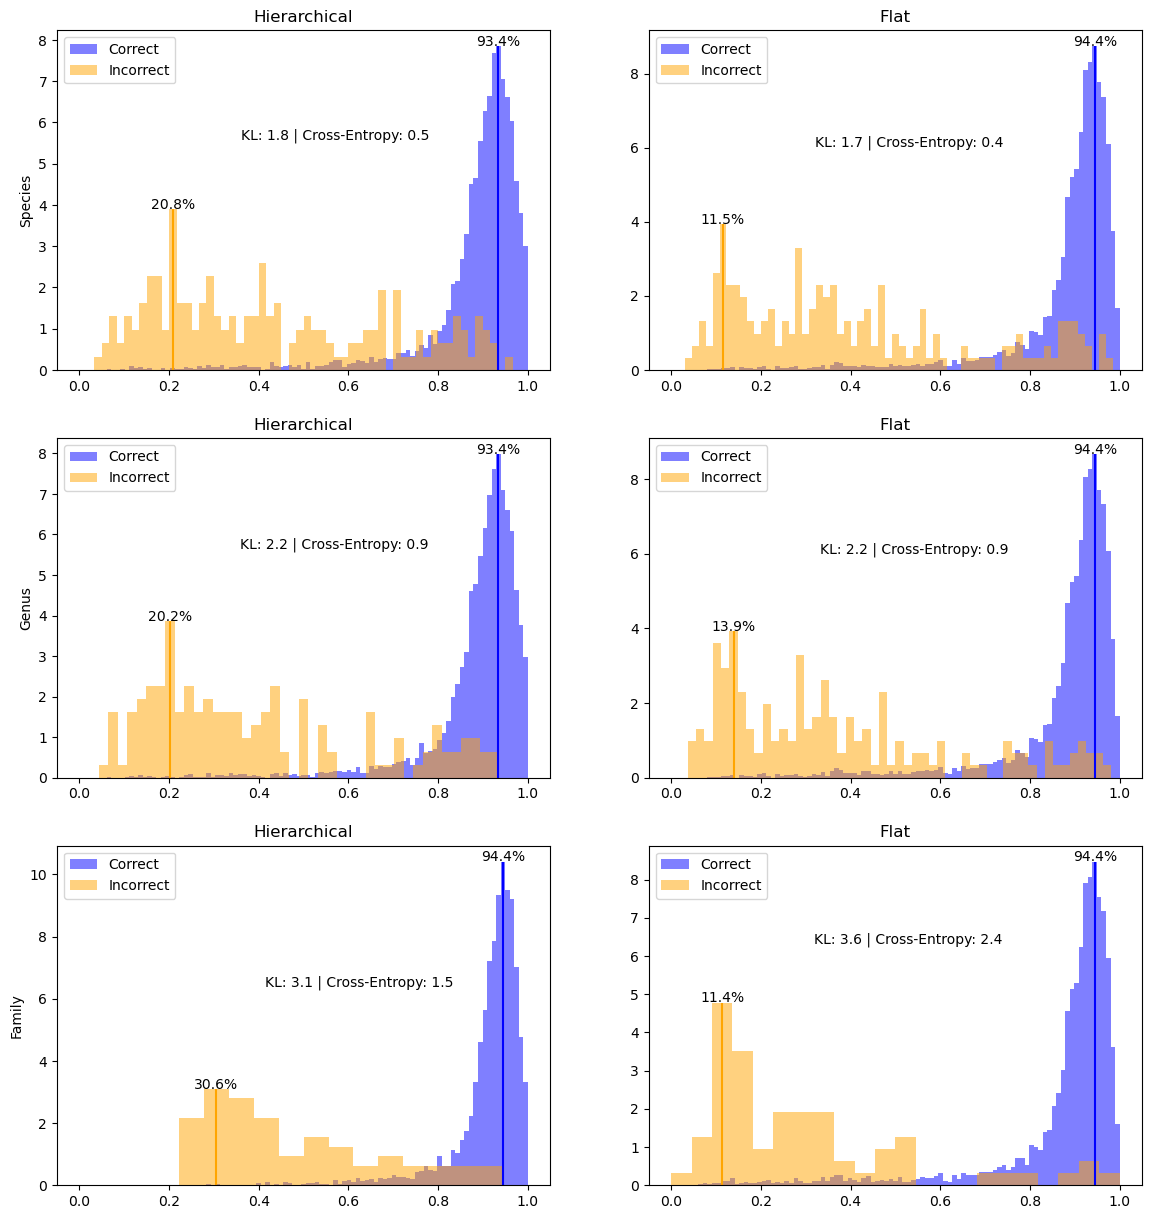

In [1321]:
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
axs : list[list[Axes]]
levels = ["Species", "Genus", "Family"]

for lvl in range(3):
    plot_conf_hist(hierarchical_data[str(lvl)]["preds"], hierarchical_data[str(lvl)]["labels"], hierarchical_data[str(lvl)]["confs"], axs[lvl][0])
    # if lvl == 0:
    axs[lvl][0].set_title("Hierarchical")
    axs[lvl][0].set_ylabel(levels[lvl])
    fdp = flat_data["preds"]
    fdp = [resolve_id(id)[levels[lvl].lower()] for id in fdp]
    fdl = flat_data["labels"]
    fdl = [resolve_id(id)[levels[lvl].lower()] for id in fdl]
    plot_conf_hist(fdp, fdl, flat_data["confs"], axs[lvl][1])
    # if lvl == 0:
    axs[lvl][1].set_title("Flat")
plt.show()

In [ ]:
import base64
from PIL import Image
import io

content = [{'box_2d': [116, 275, 788, 950], 'mask': 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AAADn0lEQVR42u2d227jMAxE+f8/PV0UyebmpI4tm6TOzEsLFFtlzlI3UlIjLMuyLMuyLMuyLMuyLMuyTpR+9e8rxe/tG13M/xfn//u94PbvQUwIQ19qIt9b7E/XIwQlcOnN2gigPQSNU8sJX0PVD4CGixn8XRnAEehI4QHUZrB33m+O4AzrpSHobOEBCA9AeADCAyiEQFmC269AQNmC208DoCL2cwhcM/gCEnhsjgfgsT1eBDw1SOsEz81JLALPramYzpvyiwI4GsJLMxIJwWsjqqqzJkJBCRhAfQBDEWhxMCjufyQBvYsAlRcewBgGeubQCsAABHqOhGYAtHvMX+wC6qPdc97iJCAKgXcAMARe/rn6RYD2DIB3O7+uY8AeBHcArmnwhmPAtdNu3QIv9Qq1FB6AtnSBUN+evx/BwyA4hTZEwEJGrDOOb5fBixngoMSAbhGgafTlKhAPIAyADaBb8mMsgUkBrGcwLwB9C0DzCQ9A3wCQkASmWPgawAAAMgAUgJJn4M7zf/9DMABCBKw4CWkAwBnAAC4L36nHgD9zQHMDWJEEm7kLrMoCTgxgXRpUcdRLMC0yALeCIDIH1PEY3Dj7l2LojAA23Ynj2Z8UwOYjMTz7EwLYdTEWaH8qANsebJ5nFBxxNxzof560OBzANM+jpPoPqv/u0+C4e4LU8O8KIIYN/i0HgcX7XbQIOPTJCMjM1zUCznk/J7j+i4dEnCi4/furk1T/UezkaIJ/OIDgviRZbyyMRMHtB/4x4XAAwP0H3b8B0P0H3H4qgKghtnv7p/9BlSQAAQcQBgAnYAAGYAAeBF9K+DQC6O1wVOoSyQGQjyBrDChDoAiAPARps0CV2bEQAFH8f3rXAg8AQqDSUlnlYkCYPvCueVhGiNsBlj8ENiecNAm4KOCqkAEYgAG4Mu4AcAAYgAHYPw2AO4ADAA1ABmD/ZADuAAbgOZAKIPWR1Xz31787yAZAj4C8O+PYqc8ADKDGEKDsR1MKLAJ8TdLbAO8DnAx1RZDu31clfU8sgUEUFN3/mQyitPAAjqcQLYQHcByCCDgBOoCAA+jhnO1fwgLwEpAMAL4HgG+CZP9OAmABQLNA7CyoC2EuBVP9488C+CiAAeAr4a4EpzCAL4HL7oLwpWCnQc4iwKx/NaoE+DCA+4DLIZ4HsAB8LM6LYZcEqAScE2ADkAF8/njTE/jzs3Fqo8f0koVfUNP/0IHi82+oCGDoWLk51I7QD4X6jF+q6+OGAAAAAElFTkSuQmCC', 'label': 'bird'}, {'box_2d': [486, 281, 715, 500], 'mask': 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AAAC/UlEQVR42u3bW1LrMAAE0dn/pudWhQrlEC4mwQ/J3fMBXxDmWJJtZCfGGGOmTm9fSm2/CB6ghJHw2bXPwR3w7wguzdD15LIDoS9EAHL5ywH0naTk9pcZBf1j6P1nJ2jhAmULtGyAbhd6fwHo/ScU6NYRgF1/NoGyBVo2QOEALVugu4bev/T+ApTef3SBwgUKB2jZAi1coHCBli3QY4MHKL3/YAI9I3iAkR6h6LnBA1QAeP+zBej9BwAovb8AAgggALp/6f0FEADe30XQKSCAAAJ4FhDA/l4ECOA5QACngADOAAHcFBNAADfGGQARQAA0QARgA0QAuAAdIHCACCCAa4AATgEBBBBAAAEEEEAAAQQQQAABvB0WQAAXAfsLQBEIXUAAAeACdICELRABBEAL4AdABXANYAPERZANkMAFBAibIAIIgAaIAAKwBQQInEAAuoAAArABEgUEIAsk9DlAF4gAAgiAFhDA/gKgBQQQQAA0QAQQgC0QuEACFxBAALZAAhfA96cLTAKwH0GmCb3/TgIJnCCBE2S+0PtvS5BZQ++/ZAi3/wfCneL1YZFrBg/wgbAOkesHD3BbIdgjIIu6tGP/nwkRbuj9jTHGGGOMMcYYY4wxZvug/+s659N37/X8DUAvfZjX+l92D2LZ7qEoYxv2sRXvcYyvDxnTBMZ6Iuvj9y0Pxej99wH46bR0VYA+T8Up+u8DcNyu/zAAJy2vGz6WejuFbv13zADQPD6/99It1u3m4sRz7JnvavT+7acXn3plgBEus84A+HrPcepl5t4A/etnzgiw1mEkgB4F0PtqN9i95lEA795t5hIAb7/728AB5rgQnvzd5zv156VsgAILgIwDcMJmwFDH/wCAxXt5y8HA6d/nETDQungUwMMICBEggwIccRv09YatY1wbHPUW2NOM/5RgnACfNz9HuDw8bDMk3zQ+G+DYRy8epR/Zt5nDY++wrn3mH/45/s4Pn7QhvMVt4gZ6522Jr1wo991NqykeLNjz89fWhJycf0UD6iO3CHHuAAAAAElFTkSuQmCC', 'label': 'insect'}]



def decode_b64_image(data : str):
    if ',' in data: data = data.split(',', 1)[1]
    mask_bytes = base64.b64decode(data)
    return Image.open(io.BytesIO(mask_bytes)).convert("RGB")

decode_b64_image(content[0]["mask"])

Error: Incorrect padding

/tmp/ipykernel_678369/721055591.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  flat_fig.show()
/tmp/ipykernel_678369/721055591.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  hier_fig.show()


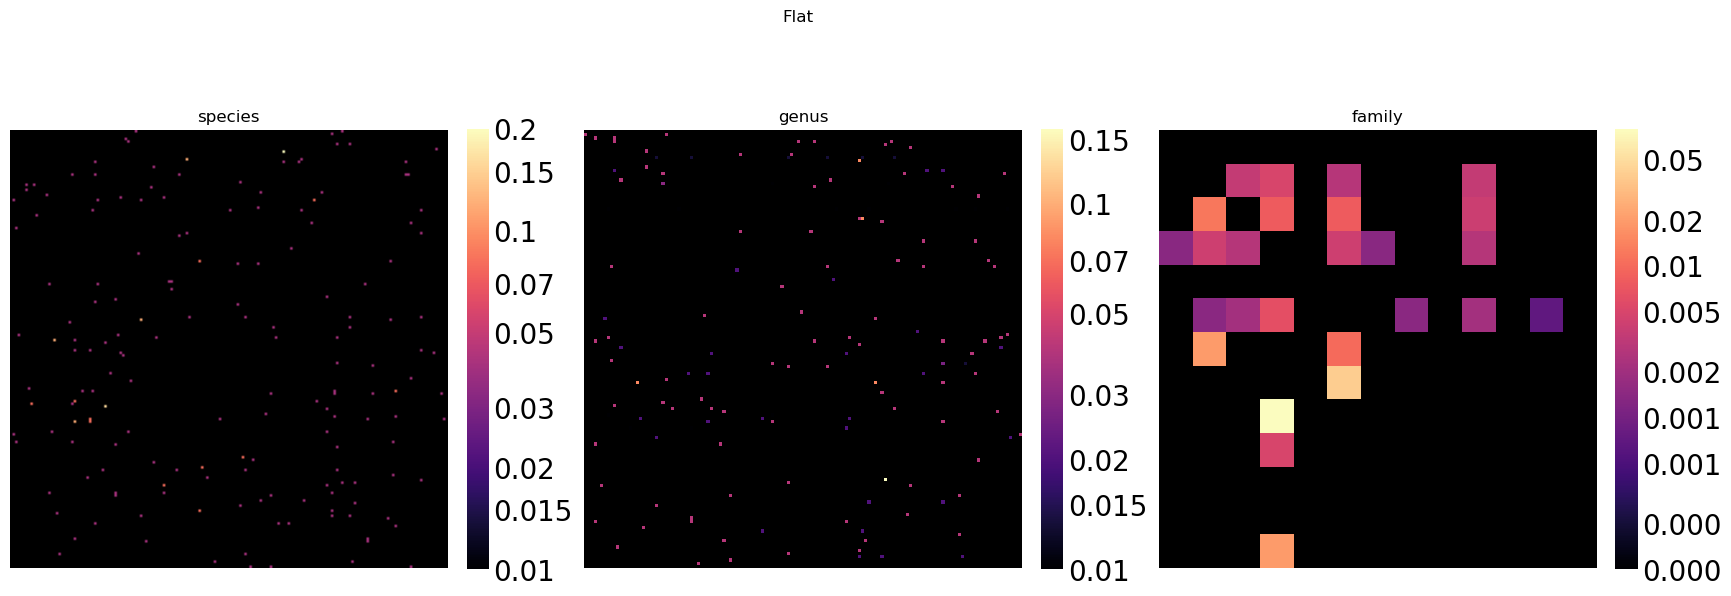

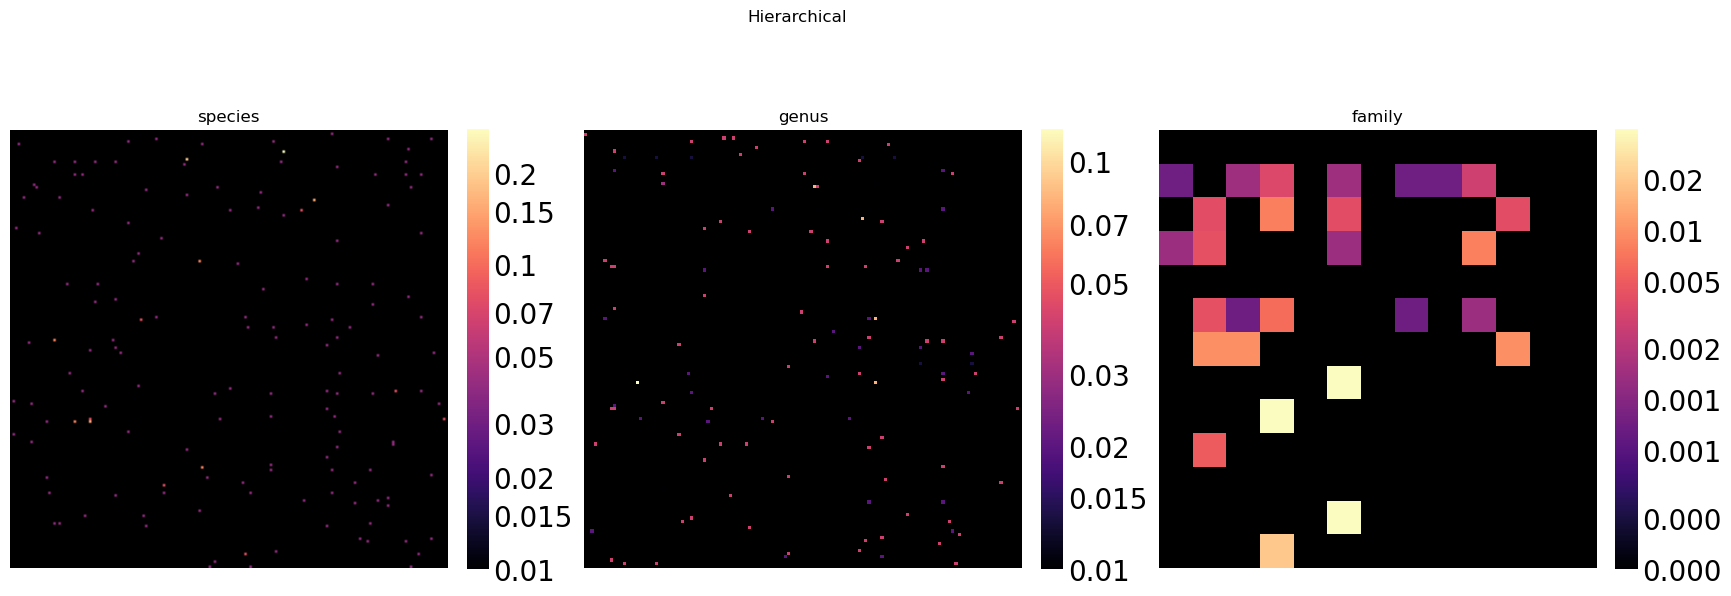

In [37]:
from itertools import chain
from hierarchical.base.integration import DEFAULT_HIERARCHY_LEVELS

from mini_trainer.utils.plot import raw_confusion_matrix, plot_heatmap

from matplotlib import pyplot as plt

def confusion_matrices(
        predictions : Union[list[Union[str, int]], list[tuple[Union[str, int], ...]]], 
        labels : list[Union[int, str]], 
        levels : int=len(DEFAULT_HIERARCHY_LEVELS),
        progress : bool=False
    ):
    cf_mats = []
    pred_long, lab_long = [[[] for _ in range(levels)] for _ in range(2)]
    elements = zip(predictions, labels)
    if progress:
        elements = TQDM(elements, total=len(labels))
    for ps, ls in elements:
        if not isinstance(ps, (list, tuple, dict)):
            ps = resolve_id(ps).values()
        ls = resolve_id(ls).values()
        for lvl, (p, l) in enumerate(zip(ps, ls)):
            if lvl >= levels:
                break
            pred_long[lvl].append(p[0])
            lab_long[lvl].append(l[0])
    comb = sorted(set(list(chain(zip(*pred_long), zip(*lab_long)))), key=lambda x : x[::-1])
    cls2idx = [{cls : i for i, cls in enumerate(set(v))} for v in zip(*comb)]
    for lvl, (preds, labs) in enumerate(zip(pred_long, lab_long)):
        cf_mats.append(raw_confusion_matrix(
            labels = [cls2idx[lvl][lab] for lab in labs],
            predictions = [cls2idx[lvl][pred] for pred in preds],
            n_classes = len(cls2idx[lvl])
        ))
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    for lvl in range(levels):
        mat = cf_mats[lvl]
        mat = np.ma.masked_array(mat, np.eye(len(mat)))
        plot_heatmap(mat, ax=axs[lvl], percent=False)
        axs[lvl].set_title(DEFAULT_HIERARCHY_LEVELS[lvl])
    return fig

# confusion_matrices(hierarchical_data["0"]["preds"], hierarchical_data["0"]["labels"]).show()
flat_fig = confusion_matrices(flat_data["preds"], flat_data["labels"])
flat_fig.suptitle("Flat")
flat_fig.show()

hier_fig = confusion_matrices(hierarchical_data["0"]["preds"], hierarchical_data["0"]["labels"])
hier_fig.suptitle("Hierarchical")
hier_fig.show()

In [23]:
from hierarchical.base.gbif import name_to_id, resolve_id
import os
from glob import glob
import shutil

from tqdm.notebook import tqdm as TQDM

flds = glob("hierarchical/test/*/*/*") + glob("hierarchical/train/*/*/*")
nms = list(sorted(set([os.path.basename(fld) for fld in flds])))
name2id = {name : name_to_id(" ".join(name.split("_")[:2])) for name in TQDM(nms)}
name2id = {name : result for name, result in sorted(name2id.items(), key=lambda x : x[1][-1])}
for name, (id, rank, conf) in name2id.items():
    if rank != "SPECIES" or conf < 90:
        raise RuntimeError(f'Inconsistent name resolution for {name} to {id} at {rank}')

new_dir = "hierarchical/restructured"
os.makedirs(new_dir, exist_ok=True)
for name, (id, rank, conf) in TQDM(name2id.items(), total=len(name2id)):
    srcs = [fld for fld in flds if fld.endswith(name)]
    id = resolve_id(id)["species"][0]
    for src in srcs:
        spl = src.split(os.sep)[1]
        dst = os.path.join(new_dir, spl, str(id))
        os.makedirs(dst, exist_ok=True)
        for _, _, files in os.walk(src):
            for file in files:
                shutil.copyfile(os.path.join(src, file), os.path.join(dst, file))


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

In [24]:
from hierarchical.base.setup import ids_to_combinations

new_ids = os.listdir(os.path.join(new_dir, "train"))
combs = ids_to_combinations(new_ids)
for id in new_ids:
    m = None
    for new_ids in combs:
        if id in new_ids:
            m = new_ids
    if m is None:
        print(id)

Querying the GBIF Species API...:   0%|          | 0/172 [00:00<?, ?it/s]

In [2]:
import pandas as pd

data = pd.read_parquet("/mnt/c/Users/asger/Downloads/0061420-241126133413365_sampled_processing_metadata_postprocessed.parquet")

In [8]:
data

gbifID      basisOfRecord          recordedBy     sex  \
0        3460025425  HUMAN_OBSERVATION         Vidar Selås    MALE   
1        3460137338  HUMAN_OBSERVATION         Vidar Selås    MALE   
2        4891462676  HUMAN_OBSERVATION         User 174396           
3        4888043413  HUMAN_OBSERVATION         User 875254  FEMALE   
4        4887572421  HUMAN_OBSERVATION         User 140514  FEMALE   
...             ...                ...                 ...     ...   
1084065  4430389597  HUMAN_OBSERVATION    Анна Васильченко           
1084066  2596134920  HUMAN_OBSERVATION        Ryzhkov Oleg           
1084067  4430408616  HUMAN_OBSERVATION    Анна Васильченко           
1084068  4908761097  HUMAN_OBSERVATION             komarov           
1084069  3327715072  HUMAN_OBSERVATION  Dmitry Dubikovskiy           

           lifeStage          eventDate       eventTime continent countryCode  \
0                            2021-05-24                    EUROPE          NO   
1                            2007-04-22                    EUROPE          NO   
2        Caterpillar         2020-06-11                    EUROPE          ES   
3              Imago         2007-07-04                    EUROPE          ES   
4              Imago         2013-07-30                    EUROPE          ES   
...              ...                ...             ...       ...         ...   
1084065               2021-06-27T11:43Z       11:43:00Z      ASIA          RU   
1084066        Adult   2016-06-10T11:21  11:21:00+03:00      ASIA          RU   
1084067               2021-06-29T10:53Z       10:53:00Z      ASIA          RU   
1084068                2021-07-10T08:23  08:23:00+07:00      ASIA          RU   
1084069                2021-06-28T10:33  10:33:00-10:00      ASIA          RU   

        stateProvince  ...                                            license  \
0               Agder  ...                              © All rights reserved   
1               Agder  ...                              © All rights reserved   
2            Albacete  ...  http://creativecommons.org/licenses/by-nc-nd/4.0/   
3                Jaén  ...  http://creativecommons.org/licenses/by-nc-nd/4.0/   
4             Granada  ...  http://creativecommons.org/licenses/by-nc-nd/4.0/   
...               ...  ...                                                ...   
1084065   Zabaykal'ye  ...        http://creativecommons.org/licenses/by/4.0/   
1084066   Zabaykal'ye  ...     http://creativecommons.org/licenses/by-nc/4.0/   
1084067   Zabaykal'ye  ...        http://creativecommons.org/licenses/by/4.0/   
1084068   Gorno-Altay  ...     http://creativecommons.org/licenses/by-nc/4.0/   
1084069   Gorno-Altay  ...     http://creativecommons.org/licenses/by-nc/4.0/   

                      rightsHolder                                  url_hash  \
0                      Vidar Selås  2ab6c7e9c8aba214f629e136b9298dcc5d009e60   
1                      Vidar Selås  d80bef036b5c5221e462765bafcb17e020e8e720   
2        Miguel Domenech Fernández  cac8cf49951a6dfe8105ca951d1f226ae9f9e567   
3              Cesar Lopezosa Mora  876b688ea462a97b3544e15737b1cd872df189d0   
4                    Paco (Faluke)  c1ea814b160d9ebd7017ea56b0bb394e352794aa   
...                            ...                                       ...   
1084065           Анна Васильченко  5436022dfcc03489a1970d7f36a46a95ab000d6b   
1084066               Ryzhkov Oleg  94bf27280b441e937c0b888e012ea167b40f464e   
1084067           Анна Васильченко  13918e604e6bdb4f4720e19b2f8ab2ed687ea822   
1084068                    komarov  e48dda42fac4145ff5171082ae4899af6e75b6f7   
1084069         Dmitry Dubikovskiy  2cdd92be4d4b8d23482cd8d593fe1fe3eb744bf0   

                                              filename  \
0        2ab6c7e9c8aba214f629e136b9298dcc5d009e60.jpeg   
1        d80bef036b5c5221e462765bafcb17e020e8e720.jpeg   
2        cac8cf49951a6dfe8105ca951d1f226ae9f9e567.jpeg   
3        876b688ea462a97b3544e157

In [1]:
import os
import json
from hierarchical.base.integration import HierarchicalBuilder
import warnings

def parquet_to_dataindex(
        path : str, 
        dir : str, 
        class_index : str,
        test_split : tuple[int, ...]=(0,),
        train_prop : float=0.9
    ):
    data = pd.read_parquet(path)

    flds, fld2spl = data["set"].tolist(), dict()
    # Allocate folds to splits
    train = val = total = test = 0
    for fld in set(flds):
        split = "test"
        if isinstance(fld, str):
            clean_fld = fld.strip()
        else:
            clean_fld = fld
        if (isinstance(clean_fld, int) or clean_fld.isdigit()) and not (int(clean_fld) in test_split):
            split = "val"
            if train == 0 or (train / max(1, train + val)) < train_prop:
                split = "train"
            # Ensure we have at least one fold in train/val (if there is more than 1 fold)
            if train > 0 and val == 0:
                split = "val"
            if split == "train":
                train += 1
            if split == "val":
                val += 1
        else:
            test += 1
        total += 1
        fld2spl[fld] = split
    if (train + val + test) != total:
        raise RuntimeError(f'Inconsistent fold-to-split allocation: {train + val + test=} != {total=}')
    if train == 0:
        warnings.warn("No folds allocated to training! May cause issues with training.")
    if val == 0:
        warnings.warn("No folds allocated to validation! May cause issues with training.")
    if test == 0:
        warnings.warn("No folds allocated to testing! Likely has no effect on training, but is likely incorrect.")
    # Translate folds to splits
    spl = [fld2spl[fld] for fld in flds]
    
    # Construct image paths by joining the data directory with the species and file name.
    paths = [os.path.join(dir, sp, fn) for sp, fn in zip(data["speciesKey"].tolist(), data["filename"].tolist())]

    # Construct index-based class labels
    with open(class_index, "r") as f:
        cls2idx = json.load(f)["cls2idx"]
    cls = [[cls2idx[str(lvl)][c] for lvl, c in enumerate(sgf)] for sgf in zip(*[data[f'{tl}Key'] for tl in ["species", "genus", "family"]])]
    
    return {
        "split" : spl,
        "class" : cls,
        "path"  : paths
    }

def parquet_to_combinations(path : str):
    data = pd.read_parquet(path)
    combinations = set()
    for sgf in zip(*[data[f'{tl}Key'] for tl in ["species", "genus", "family"]]):
        combinations.add(tuple(sgf))
    return [list(sgf) for sgf in sorted(combinations)]


# parquet_to_dataindex("/mnt/c/Users/asger/Downloads/0061420-241126133413365_sampled_processing_metadata_postprocessed.parquet")

HierarchicalBuilder.spec_model_dataloader(
    "test.json",
    "/mnt/c/Users/asger/Downloads/0061420-241126133413365_sampled_processing_metadata_postprocessed.parquet",
    parquet_to_combinations
)

with open("test_di.json", "w") as f:
    di = parquet_to_dataindex(
        "/mnt/c/Users/asger/Downloads/0061420-241126133413365_sampled_processing_metadata_postprocessed.parquet",
        "test",
        "test.json"
    )
    json.dump(di, f)

NameError: name 'pd' is not defined

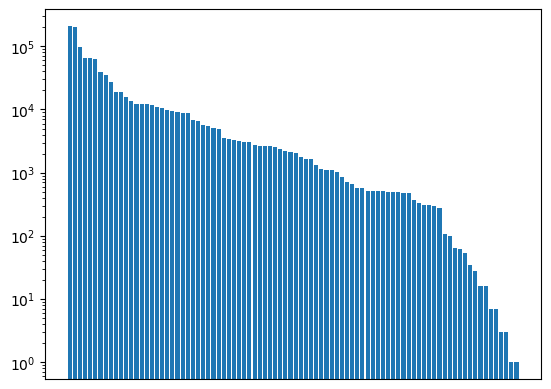

In [62]:
from matplotlib import pyplot as plt

from collections import Counter

plt.bar(*zip(*sorted(Counter([str(cls[2]) for cls in di["class"]]).items(), key=lambda x : x[1], reverse=True)))
plt.xticks([])
plt.yscale("log")
plt.show()

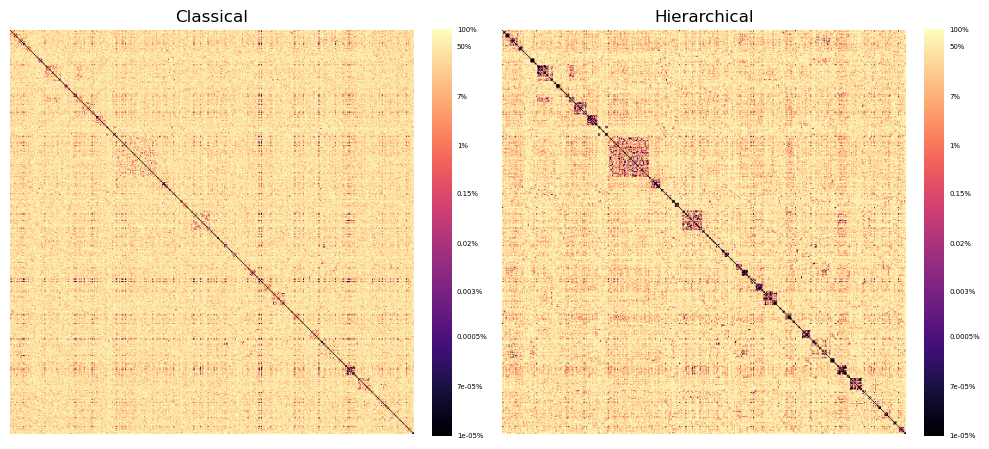

In [1]:
from mini_trainer.builders import BaseBuilder
from hierarchical.base.integration import HierarchicalBuilder

from mini_trainer.utils.plot import plot_model_class_distance

import torch
from matplotlib import pyplot as plt

device, dtype = torch.device("cuda:0"), torch.float32

cmod, cproc = BaseBuilder.build_model(
    model_type = "efficientnet_b0",
    weights = "hierarchical/flat_v2.pt",
    device=device
)
cmod.eval()

hmod, hproc = HierarchicalBuilder.build_model(
    model_type = "efficientnet_b0",
    weights = "hierarchical/hierarchical_v2.pt",
    device=device
)
hmod.eval()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_model_class_distance(
    cmod, ax = axs[0], font_size=5, min_val=1e-7
)
axs[0].set_title("Classical")

plot_model_class_distance(
    hmod, ax = axs[1], font_size=5, min_val=1e-7
)
axs[1].set_title("Hierarchical")

plt.tight_layout()
plt.show()

In [ ]:
from examples.hierarchical.base.gbif import name_to_id, resolve_id
from examples.hierarchical.base.setup import ids_to_combinations

from glob import glob
import os

trf = glob("hierarchical/train/*/*/*")
trs = [os.path.basename(f).replace("_", " ") for f in trf]
tri = list(map(name_to_id, trs))
comb = ids_to_combinations([i[0] for i in tri])


Querying the GBIF Species API...:   0%|          | 0/172 [00:00<?, ?it/s]

In [3]:
from mini_trainer.utils.io import ImageLoader
import json

with open("hierarchical/gmo_traits_class_index.json", "r") as f:
    cls2idx = json.load(f)
idx2cls = {v : k for k, v in cls2idx.items()}

In [4]:
from collections import defaultdict
from tqdm.notebook import tqdm as TQDM

f2c = {f : tuple(c) for f, c in zip(trf, comb)}

preds = defaultdict(list)

with torch.inference_mode():
    for f, c in TQDM(f2c.items()):
        ims = sorted(os.listdir(f))
        ims = [os.path.join(f, im) for im in ims[:min(len(ims), 5)]]
        for im in ImageLoader(cproc, dtype, device)(ims):
            out = cmod(im.unsqueeze(0)).squeeze(0)
            preds[c].append([(idx, idx2cls[idx]) for idx in out.argsort()[:5].tolist()])

  0%|          | 0/172 [00:00<?, ?it/s]

In [ ]:
# from functools import cache

def compare_id_or_name(id_or_name1 : str, id_or_name2 : str) -> int:
    id_or_name1 = id_or_name1.strip()
    if id_or_name1.isdigit():
        id1 = int(id_or_name1)
    else:
        id1 = name_to_id(id_or_name1)[0]
    id_or_name2 = id_or_name2.strip()
    if id_or_name2.isdigit():
        id2 = int(id_or_name2)
    else:
        id2 = name_to_id(id_or_name2)[0]
    lku1 = resolve_id(str(id1))
    lku2 = resolve_id(str(id2))
    for i, lvl in enumerate(lku1.keys()):
        if lku1[lvl][0] == lku2[lvl][0]:
            return i
    return i + 1

In [22]:
set([r["family"][-1] for r in map(resolve_id, TQDM(cls2idx))])

  0%|          | 0/470 [00:00<?, ?it/s]

{'Hesperiidae',
 'Lycaenidae',
 'Nymphalidae',
 'Papilionidae',
 'Pieridae',
 'Riodinidae'}

In [6]:
preds_id2id = {k[0] : [[e[-1] for e in p] for p in v] for k, v in preds.items()}

In [16]:
{k : [[compare_ids(k, e) for e in p] for p in v] for k, v in TQDM(preds_id2id.items())}

  0%|          | 0/172 [00:00<?, ?it/s]

{'5772063': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '1782777': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '1782672': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '4522753': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '5769072': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '5769062': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '5769068': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '1861644': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '1771214': [[3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3]],
 '1771245': [[3, 3, 3, 3, 3],
  [3, 3

In [ ]:
import json
from matplotlib import pyplot as plt
import torch
from PIL import Image
from typing import dict, list, Union, tuple
import numpy as np
from matplotlib.axes import Axes
from math import prod

In [ ]:
with open("quality_control.json", "rb") as f:
    qc = json.load(f)

with open("quality/class_description.json", "rb") as f:
    cls2desc = json.load(f)

with open("quality/class_index.json", "rb") as f:
    cls2idx = json.load(f)

cls2desc = {k : v.strip().split(":")[0] for k, v in cls2desc.items()} 

print("Quality control output length (should be equal):\n", {k : len(v) for k, v in qc.items()})
# print(cls2desc)

def plot_ecdf(ax : Axes, arr : np.ndarray, hist : bool=True):
    x = np.sort(arr)
    y = np.arange(1, len(x) + 1) / len(x)
    ax.step(x, y, where='post')
    if hist:
        counts, bins = np.histogram(arr, min(100, max(10, len(arr) // 15)))
        counts = counts.astype(np.float64)
        counts /= counts.max()
        ax.stairs(counts, bins, fill=True)
        ax.set_ylabel("Cumulative & Relative density")
    else:
        ax.set_ylabel("Cumulative density")
    ax.set_xlabel("Confidence")

def reshape_ind(idx : np.ndarray, shape : tuple[int, ...]):
    idx = idx.copy()
    out = np.zeros((len(idx), len(shape))).astype(idx.dtype)
    cp = [prod(shape[:i]) for i in range(len(shape))]
    for di in reversed(range(len(shape))):
        out[:, di] = idx // cp[di]
        idx -= cp[di] * out[:, di]
    if out.shape[1] == 1:
        out = out.reshape(len(out))
    return out

def spaced_ind_along(arr, im_per_cls):
    s = arr.shape
    n = prod(s)
    q = np.linspace(0, 1-1/n, im_per_cls, endpoint=True)
    i = np.round(q * n, decimals=0).astype(np.long)
    return reshape_ind(i, s)

def plot_qc(qc_result : dict[str, list[Union[str, float, int]]], im_per_cls : int=4, conf_sort : bool=False):
    paths, clsl, conf = [qc_result[k] for k in ["path", "pred", "conf"]]
    conf = np.array(conf)
    clsv = np.array([cls2idx[cls] for cls in clsl])

    fig, axs = plt.subplots(len(cls2idx), (1+im_per_cls), figsize=((1+im_per_cls)*5, len(cls2idx)*3))
    # fig, axs = plt.subplots(len(cls2idx), 1, figsize=(5, 5*len(cls2idx)))

    for axi, cls in enumerate(sorted(list(cls2idx))):
        cm = clsv == cls2idx[cls]
        any_obs = bool(sum(cm) > 0)
        wi = np.where(cm)[0]
        if not any_obs:
            wi = np.zeros((im_per_cls, ))
        elif conf_sort:
            wi = wi[conf[cm].argsort(0)[::-1]][spaced_ind_along(wi, im_per_cls)]
        else:
            wi = wi[:im_per_cls]
        for axj, i in enumerate(wi, 1):
            if any_obs:
                im = Image.open(paths[i])
                ax = axs[axi, axj]
                ax.imshow(im)
                ax.set_title(f'{cls2desc[cls]} ({conf[i]:.1%})')
            ax.axis("off")
        if any_obs:
            plot_ecdf(axs[axi, 0], conf[cm], True)
plot_qc(qc, im_per_cls=20, conf_sort=True)
plt.tight_layout()
# plt.show()
plt.savefig("test_quality_control.jpg", dpi=300)
plt.close()

In [ ]:
num_valid_above_80 = sum([1 if qc["pred"][i] == "1" and qc["conf"][i] > 0.8 else 0 for i in range(len(qc["path"]))])
print(f'Found {num_valid_above_80} images classified as valid with above 80% confidence.\nThis corresponds to {num_valid_above_80/len(qc["path"]):.1%} of all images, or {num_valid_above_80/len([e for e in qc["pred"] if e == "1"]):.1%} of images classified as valid.')

In [1]:
import json
from random import sample

import numpy as np
import torch
from PIL import Image

from mini_trainer.builders import BaseBuilder

with open("quality/class_description.json", "rb") as f:
    cls2desc = {k : v.strip().split(":")[0] for k, v in json.load(f).items()}

with open("quality/class_index.json", "rb") as f:
    cls2idx = json.load(f)

sidxs = sample(range(len(qc["path"])), 5)
qc5 = {k : np.concat(smpl) if isinstance(v, np.ndarray) else smpl for k, v in qc.items() if (smpl := [v[i] for i in sidxs])}
idx2cls = {v : k for k, v in cls2idx.items()}

dev, dt = torch.device("cuda:0"), torch.float32

qcmodel, mproc = BaseBuilder.build_model(
    model_type="efficientnet_v2_s",
    weights="quality/efficientnet_v2_s_full_e15.pt",
    device=dev,
    dtype=dt,
    num_classes=len(cls2desc)
)
qcmodel.eval()

def load_image(path):
    return mproc(torch.tensor(np.array(Image.open(path)).copy()).permute(2,0,1).float() / 255.)


with torch.inference_mode():
    with torch.autocast(dev.type, dt):
        tout = qcmodel(torch.stack([load_image(p) for p in qc5["path"]]).to(dev, dt)).cpu()
    tconfs = tout.softmax(1)
    tconf, tpred = tconfs.max(1).values, tout.argmax(1)
    tcls = [idx2cls[i.item()] for i in tpred]

for i in range(5):
    print("_"*60)
    print(f"PREdictION #{i}")
    print(f"Model output: [{', '.join([f'{v:.1f}' for v in tout[i]])}]")
    print(f"Model confidences: [{', '.join([f'{c.item():.0%}' for c in tconfs[i]])}]")
    print(f"Model prediction & confidence: {cls2desc[tcls[i]]} ({tconf[i]:.1%})")

    print(f"Saved/Predicted confidence: {qc5["conf"][i]:.1%}/{tconf[i]:.1%}")
    print(f"Saved/Predicted class: {qc5["pred"][i]}/{tcls[i]}")
    print()
    print()

NameError: name 'qc' is not defined

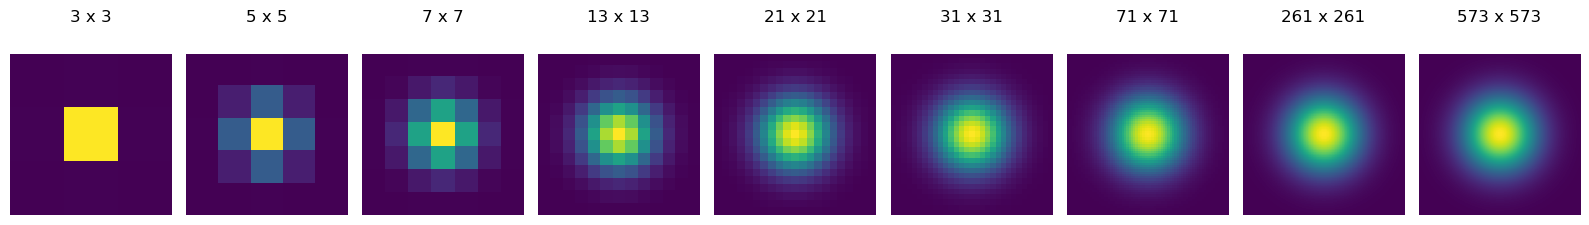

: 

In [ ]:
# Creates a gaussian kernel with the specified shape
def gk(shape):
    sran = torch.tensor([(d - 1) / 2. for d in shape]).unsqueeze(1)
    idx = torch.stack([t.flatten() for t in torch.meshgrid([torch.arange(d) for d in shape], indexing="ij")]).float()
    idx -= sran
    idx /= sran / torch.pi
    dens = torch.exp(-(idx ** 2).sum(0)/2)
    return dens.reshape(shape) / sum(dens)

fig, axs = plt.subplots(1, 9, figsize=(16, 2.25))

ks = [3, 5, 7, 13, 21, 31, 71, 261, 573]

for i, ax in enumerate(axs.flatten()):
    s = ks[i]
    ax.matshow(gk((s,s)))
    ax.axis("off")
    ax.set_title(f'{s} x {s}')
    ax.set_box_aspect(1)

plt.tight_layout()
plt.show()

In [ ]:
from mini_trainer.utils.plot

NameError: name 'gk' is not defined

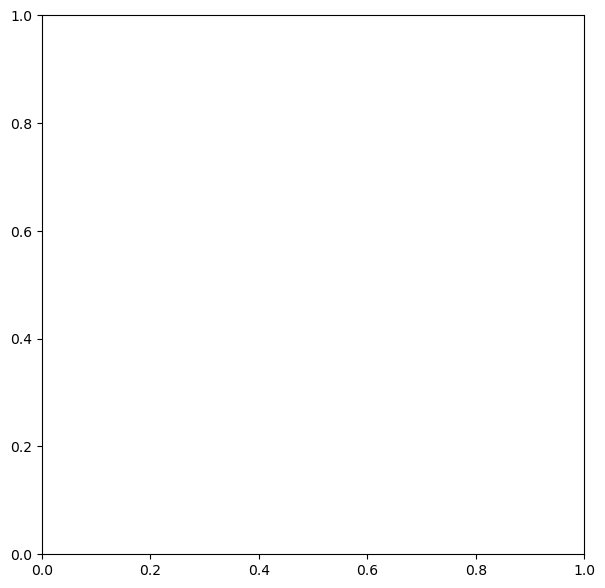

In [1]:
import numpy as np
import torch
from hierarchical.base.integration import (hierarchical_model_builder,
                                           hierarchical_parse_class_index)
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dev, dt = torch.device("cuda:0"), torch.float32

model_builder_kwargs, other_args = hierarchical_parse_class_index("gmo_traits_class_index.json")
model, mproc = hierarchical_model_builder(
    model = "efficientnet_v2_s",
    weights = "hierarchical/gmo_traits.pt",
    fine_tune=False,    
    device=dev,
    dtype=dt,
    **model_builder_kwargs
)
model.eval()

masks = model_builder_kwargs["masks"]
cls2idx = other_args["class2idx"]
idx2cls = other_args["idx2class"]
gns = [row.nonzero().flatten().long() for row in (masks[0] + 100)]
fns = [row.nonzero().flatten().long() for row in (((masks[0] + 100)/100).T @ ((masks[1] + 100)/100).T).T]

llw = model.classifier.linear.weight.data.cpu().to(torch.float64)

llw -= llw.mean(dim = 1, keepdim=True)
llw /= llw.std(dim = 1, unbiased=True, keepdim=True)
llwn = llw.norm(2, dim=1)


cos_mat = (llw @ llw.T) / (llwn.unsqueeze(0) * llwn.unsqueeze(1))
eucl_mat = torch.cdist(llw, llw)
eucl_cdf_mat = torch.distributions.Chi2(llw.shape[1]).cdf((eucl_mat.cpu() ** 2 / 2))

# assume conf_mat (n×n) and cls_types are defined
cmap = plt.get_cmap('tab20')
n_types = len(fns)
colors = [cmap(i) for i in range(n_types)]
n_classes = eucl_cdf_mat.shape[0]

# build an RGBA list for each class
fam_colors = np.zeros((n_classes, 4))
for t, idxs in enumerate(fns):
    fam_colors[idxs] = colors[t]

gen_colors = np.zeros((n_classes, 4))
for t, idxs in enumerate(gns):
    gen_colors[idxs] = colors[t % len(colors)]

fig, ax = plt.subplots(figsize=(7, 7))

im = ax.matshow(torch.nn.functional.conv2d(eucl_cdf_mat.clone().float().unsqueeze(0).unsqueeze(0), gk((1,1,1,1))).reshape(*eucl_mat.shape).fill_diagonal_(torch.nan))
ax.axis("off")
plt.colorbar(im, ax=ax)

# shrink the heatmap to make room for the bars
bar_sz = 0.02
pos = ax.get_position()  # Bbox(x0, y0, width, height)
ax.set_position([
    pos.x0 + 1*bar_sz,
    pos.y0 + 1*bar_sz,
    pos.width - 1*bar_sz,
    pos.height - 1*bar_sz
])

# horizontal bar (just above the heatmap)
ax_top1 = fig.add_axes([
    pos.x0 + bar_sz,
    pos.y0 + pos.height,
    pos.width - bar_sz,
    bar_sz
])
ax_top1.imshow(fam_colors[None, :, :], aspect='auto')
ax_top1.axis('off')
ax_top2 = fig.add_axes([
    pos.x0 + bar_sz,
    pos.y0 + pos.height + bar_sz,
    pos.width - bar_sz,
    bar_sz
])
ax_top2.imshow(gen_colors[None, :, :], aspect='auto')
ax_top2.axis('off')

# vertical bar (just to the left of the heatmap)
ax_left1 = fig.add_axes([
    pos.x0,
    pos.y0 + bar_sz,
    bar_sz,
    pos.height - bar_sz
])
ax_left1.imshow(fam_colors[:, None, :], aspect='auto')
ax_left1.axis('off')
ax_left2 = fig.add_axes([
    pos.x0 - bar_sz,
    pos.y0 + bar_sz,
    bar_sz,
    pos.height - bar_sz
])
ax_left2.imshow(gen_colors[:, None, :], aspect='auto')
ax_left2.axis('off')

plt.show()

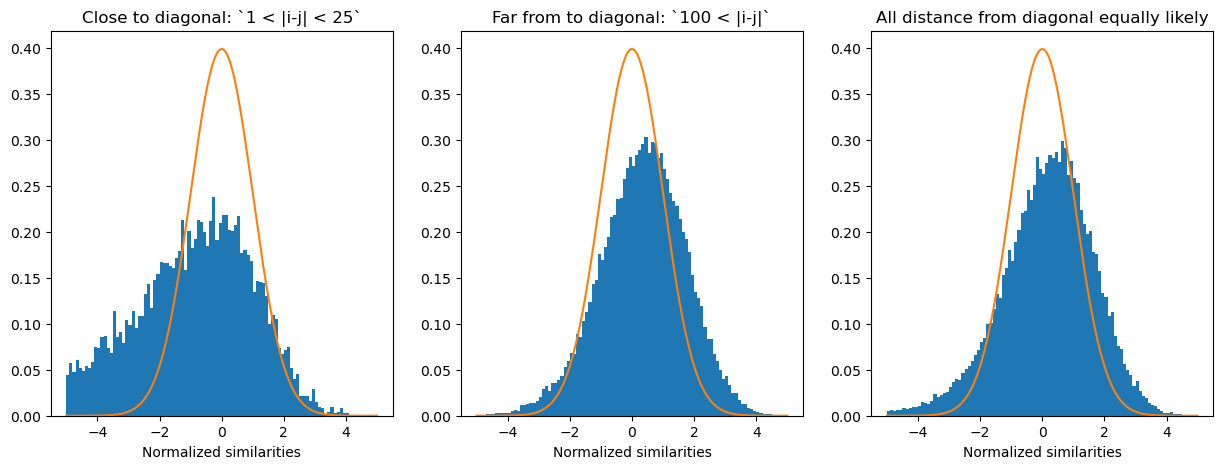

In [266]:
def plot_weighted_diag_hist(M, ax=None, bins=100, range=(-5, 5)):
    N = M.shape[0]
    v = M.ravel()
    idx = np.arange(N)
    d = np.abs(idx[:, None] - idx[None, :]).ravel()
    w = 1.0 / np.bincount(d, minlength=N)[d]
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(v, bins=bins, range=range, weights=w, density=True)
    return ax

eucl_mat_norm = torch.distributions.Normal(0, 1).icdf(eucl_cdf_mat.to(torch.float64))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ne_x, ne_y = torch.arange(-5, 5, 0.001), torch.distributions.Normal(0, 1).log_prob(torch.arange(-5, 5, 0.001)).exp()

ax1.hist(
    eucl_mat_norm[
        *torch.where(
            torch.logical_and(torch.tril(torch.ones_like(eucl_cdf_mat), -1), torch.logical_not(torch.tril(torch.ones_like(eucl_cdf_mat), -25)))
        )
    ].flatten(), 
    range=(-5, 5), bins=100, density=True
)
ax1.plot(ne_x, ne_y)
ax1.set_xlabel("Normalized similarities")
ax1.set_title("Close to diagonal: `1 < |i-j| < 25`")

ax2.hist(
    eucl_mat_norm[*torch.where(torch.tril(torch.ones_like(eucl_cdf_mat), -200))].flatten(), 
    range=(-5, 5), bins=100, density=True
)
ax2.plot(ne_x, ne_y)
ax2.set_xlabel("Normalized similarities")
ax2.set_title("Far from to diagonal: `100 < |i-j|`")

# ax3.hist(
#     eucl_mat_norm[*torch.where(torch.tril(torch.ones_like(eucl_cdf_mat), -1))].flatten(), 
#     range=(-6, 6), bins=100, density=True
# )
plot_weighted_diag_hist(
    eucl_mat_norm,
    ax3,
    bins=100,
    range=(-5,5)
)
ax3.plot(ne_x, ne_y)
ax3.set_xlabel("Normalized similarities")
ax3.set_title("All distance from diagonal equally likely")

plt.show()

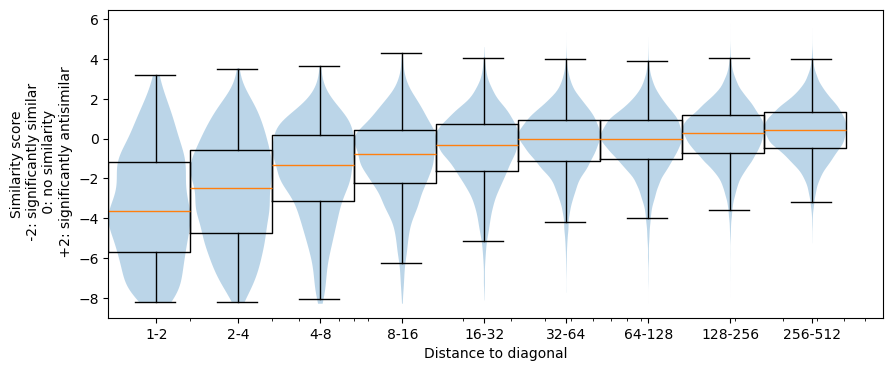

In [268]:
def plot_diag_distributions(M, bins=10, ax=None):
    N = M.shape[0]
    idx = np.arange(N)
    i_mat, j_mat = np.meshgrid(idx, idx, indexing='ij')
    mask = i_mat > j_mat                # lower triangle only, excludes diagonal
    d = (i_mat - j_mat)[mask]
    v = M[mask]

    edges = np.histogram_bin_edges(d, bins=bins)
    bin_idx = np.digitize(d, edges) - 1
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)
    groups, positions, widths_plot = [], [], []
    for k, (c, w) in enumerate(zip(centers, widths)):
        vals = v[bin_idx == k]
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            continue
        if vals.size == 1:               # duplicate singletons so violin can render
            vals = np.concatenate([vals, vals])
        groups.append(vals)
        positions.append(c)
        widths_plot.append(w)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xscale("log")
    ax.violinplot(groups, positions=positions, widths=widths_plot, showextrema=False)
    ax.boxplot   (groups, positions=positions, widths=widths_plot, showfliers=False)
    ax.set_xlabel('Distance to diagonal')
    ax.set_ylabel('Similarity score\n -2: significantly similar\n 0: no similarity\n +2: significantly antisimilar')
    ax.set_xticks(centers, [f'{l}-{r}' if not can_round else f'{int(lr)}-{int(rr)}' for l, r in zip(edges[:-1], edges[1:]) if not isinstance(can_round := (np.isclose(l, lr := np.round(l)) and np.isclose(r, rr := np.round(r))), list)])
    return ax

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_diag_distributions(
    eucl_mat_norm.clone().numpy(),
    2 ** np.arange(0, np.ceil(np.log2(len(eucl_mat_norm)))+1, 1),
    ax
)
pass

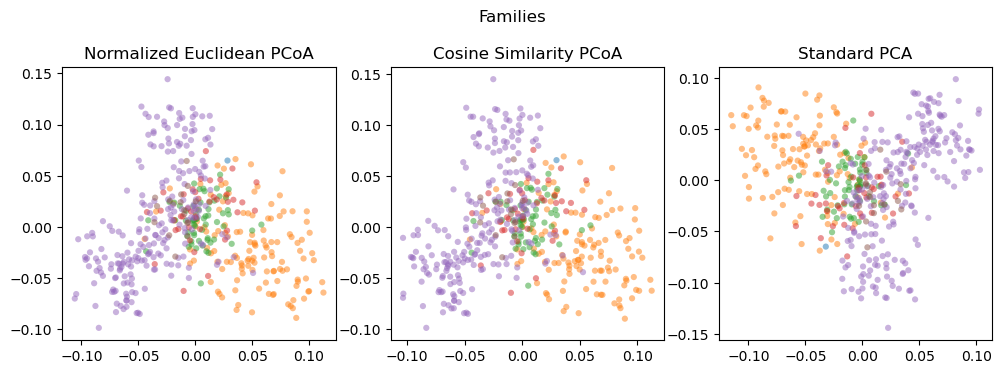

In [269]:
eucl_mat_norm_f = eucl_mat_norm.clone()
eucl_mat_norm_f[torch.logical_and(~torch.isfinite(eucl_mat_norm), eucl_mat_norm < 0)] = -10
eucl_mat_norm_f[torch.logical_and(~torch.isfinite(eucl_mat_norm), eucl_mat_norm > 0)] = 10
pxy_en = torch.svd_lowrank(eucl_mat_norm_f, 2, niter=100)[0].cpu()
pxy_cs = torch.svd_lowrank(cos_mat, 2, niter=100)[0].cpu()
pxy_st = torch.pca_lowrank(llw, 2, niter=100)[0].cpu()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

sc_args = {
    "s" : 20,
    "alpha" : 0.5,
    "edgecolors" : "none"
}

for gn in gns:
    ax1.scatter(*pxy_en[gn].T, **sc_args)
    ax1.set_box_aspect(1)
    ax2.scatter(*pxy_cs[gn].T, **sc_args)
    ax2.set_box_aspect(1)
    ax3.scatter(*pxy_st[gn].T, **sc_args)
    ax3.set_box_aspect(1)
ax1.set_title("Normalized Euclidean PCoA")
ax2.set_title("Cosine Similarity PCoA")
ax3.set_title("Standard PCA")

fig.suptitle("Genera")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

for fn in fns:
    ax1.scatter(*pxy_en[fn].T, **sc_args)
    ax1.set_box_aspect(1)
    ax2.scatter(*pxy_cs[fn].T, **sc_args)
    ax2.set_box_aspect(1)
    ax3.scatter(*pxy_st[fn].T, **sc_args)
    ax3.set_box_aspect(1)
ax1.set_title("Normalized Euclidean PCoA")
ax2.set_title("Cosine Similarity PCoA")
ax3.set_title("Standard PCA")
fig.suptitle("Families")
plt.show()


In [ ]:
import sys
from importlib import util
from types import ModuleType
from pathlib import Path
import json

def import_module_from_folder(folder: str, module_name: str, package_name: str = None):
    """
    Dynamically imports a module from a folder that uses relative imports.

    :param folder: Path to the project folder (must contain __init__.py).
    :param module_name: Name of the .py file (without .py) to import.
    :param package_name: Package name to assign (defaults to folder name).
    :return: The imported module.
    """
    folder = Path(folder).resolve()
    pkg_name = package_name or folder.name

    # 1) Create and register the package
    pkg = ModuleType(pkg_name)
    pkg.__path__ = [str(folder)]
    sys.modules[pkg_name] = pkg

    # 2) Build spec for the submodule
    full_mod_name = f"{pkg_name}.{module_name}"
    file_path = folder / f"{module_name}.py"
    spec = util.spec_from_file_location(full_mod_name, str(file_path))

    # 3) Create, register, and execute the module
    mod = util.module_from_spec(spec)
    sys.modules[full_mod_name] = mod
    spec.loader.exec_module(mod)

    return mod

m = import_module_from_folder("/home/asger/structured-analysis", "plots")

with open("taxonomy_store.json", "rb") as f:
    taxonomy = json.load(f)
    species_labels = [taxonomy[idx2cls[2][i]]["family"][1] for i in range(len(idx2cls[2]))]

m.hierarchical_cluster_llw(model.classifier.linear.weight.data.cpu(), species_labels)

{'1946661': {'family': ['6953', 'Hesperiidae'], 'genus': ['1946647', 'Borbo'], 'species': ['1946661', 'Borbo borbonica']}, '8277078': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['8277078', 'Carcharodus alceae']}, '4535386': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['4535386', 'Carcharodus baeticus']}, '1943397': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['1943397', 'Carcharodus floccifera']}, '8178854': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['8178854', 'Carcharodus lavatherae']}, '1943388': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['1943388', 'Carcharodus stauderi']}, '1947335': {'family': ['6953', 'Hesperiidae'], 'genus': ['1947272', 'Carterocephalus'], 'species': ['1947335', 'Carterocephalus palaemon']}, '1947306': {'family': ['6953', 'Hesperiidae'], 'genus': ['1947272', '

[347,
 336,
 373,
 371,
 272,
 351,
 361,
 374,
 377,
 362,
 259,
 343,
 364,
 370,
 345,
 365,
 379,
 348,
 342,
 353,
 363,
 340,
 422,
 358,
 366,
 368,
 355,
 376,
 359,
 380,
 341,
 344,
 356,
 339,
 369,
 381,
 350,
 360,
 375,
 337,
 346,
 357,
 238,
 419,
 240,
 237,
 242,
 258,
 283,
 290,
 294,
 284,
 289,
 286,
 288,
 297,
 291,
 287,
 296,
 415,
 417,
 285,
 414,
 416,
 230,
 418,
 431,
 430,
 432,
 434,
 433,
 435,
 293,
 278,
 277,
 279,
 327,
 326,
 329,
 300,
 303,
 307,
 398,
 302,
 304,
 295,
 305,
 229,
 292,
 306,
 308,
 299,
 298,
 301,
 354,
 420,
 328,
 330,
 367,
 372,
 378,
 338,
 349,
 352,
 400,
 280,
 412,
 392,
 411,
 395,
 410,
 391,
 404,
 401,
 406,
 394,
 393,
 408,
 407,
 397,
 403,
 409,
 413,
 399,
 405,
 396,
 402,
 250,
 256,
 251,
 254,
 276,
 252,
 255,
 111,
 113,
 34,
 30,
 31,
 123,
 125,
 122,
 124,
 126,
 73,
 108,
 17,
 19,
 116,
 32,
 33,
 70,
 104,
 105,
 18,
 100,
 16,
 119,
 25,
 74,
 45,
 47,
 42,
 44,
 46,
 43,
 48,
 77,
 64,
 65,
 20